In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import os
import time
import random
import copy
import seaborn as sns
from utils.metrics import *

In [2]:
# setting random seed
SEED=42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [3]:
dicnpy='../../venv/dataCIC2017/'
dicdata='../../venv/Datasets/CIC2017/'
groupnames=["Tuesday","Wednesday","Thursday","Friday"]#"Monday",
attack_types={0:"BENIGN",1:"FTP-Patator", 2:"SSH-Patator", 3:"DoS GoldenEye", 4:"DoS Hulk", 5:"DoS Slowhttptest", 6:"DoS slowloris", 7:"Heartbleed", 
                  8:"Web Attack � Brute Force", 9:"Web Attack � XSS", 10:"Web Attack � Sql Injection", 11:"Infiltration",12:"Bot", 13:"DDoS", 14:"PortScan",15:"AllAttack"} # "Web Attack ?Brute Force"
    # Web Attack ?Brute Force, Web Attack ?XSS, Web Attack ?Sql Injection 
dicoutcome='../../venv/MyBayesian/cic2017_checkpoints/'

In [4]:
def column_split_bina(ds):
    '''split dataset to data_x,data_y for binary classification '''
    if type(ds)==pd.DataFrame:
        data_x=np.asarray(ds.iloc[:,:-2]).astype(np.float32)
        data_y=np.asarray(ds.iloc[:,-1]).astype(np.float32)
    elif type(ds)==np.ndarray:
        data_x=ds[:,:-2].astype(np.float32)
        data_y=ds[:,-1].astype(np.float32)        
    else:
        data_x=False
        data_y=False
    return data_x, data_y

In [5]:
# Get the training data
try:
    normal_all=np.load(dicnpy+'Monday-0.npy', allow_pickle=True) 
except IOError:
    print("Monday-0.npy didn't exist!")
    
normal_train_x, _ =column_split_bina(normal_all)
normal_train_x = np.nan_to_num(normal_train_x)
original_dim = normal_train_x.shape[1]
klw=normal_train_x.shape[0]
input_shape = (original_dim,)
latent_inputs =tfk.Input(shape=(64,), name='z_sampling')

# BAE

In [6]:
# from tensorflow distribution

# Normal distribution
def make_n_prior(shape, dtype=np.float32,independent=False):
    if independent:
        return   tfd.Independent(tfd.Normal(loc=tf.zeros(shape), scale=1),  reinterpreted_batch_ndims=1)
    else:
        return tfd.Normal(loc=tf.zeros(shape), scale=1)

tfb = tfp.bijectors
# make_mvn_prior(64) # MVN diag
# make_mvn_prior(64,offdiag=True)  # MVN Tril
def make_mvn_prior(ndim, trainable=False, offdiag=False):
        if not trainable:
            if offdiag:
                # With covariances
                # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.zeros(ndim),
                    scale_tril=tf.eye(ndim)
                )
            else:            
                if True:  # kl_exact needs same dist types for prior and latent.
                    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
                else:
                    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                            reinterpreted_batch_ndims=1)
        else:
            # Note, in TransformedVariable, the initial value should be that AFTER transform; weight trainable.
            if offdiag:
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_tril=tfp.util.TransformedVariable(
                        tf.random.normal([ndim, ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        tfb.FillScaleTriL(), name="prior_scale")
                )
            else:
                scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
                prior = tfd.MultivariateNormalDiag(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_diag=tfp.util.TransformedVariable(
                        tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)]),
                        name="prior_scale"
                    )
                )                
        return prior

## VI

In [ ]:
# from TensorFlow probabilities

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
        
    return tf.keras.Sequential([    
       
            #tfp.layers.VariableLayer(
           #     tfp.layers.MultivariateNormalTriL.params_size(2* n), dtype=dtype            ),
           # tfp.layers.MultivariateNormalTriL(t[..., :n] ,1e-5 + tf.nn.softplus(c + t[..., n:]) ),
                                    
        # 3.Tril
        tfp.layers.VariableLayer( 2*n, dtype=dtype),
        tfp.layers.DistributionLambda(              
            
          lambda t: tfp.distributions.MultivariateNormalTriL( t[..., :n])
            #  t[..., :n] ,1e-5 + tf.nn.softplus(c + t[..., n:]) ),
          ) 
        
        # 2.MVN
         # lambda t: tfp.distributions.MultivariateNormalDiag(
               ##loc=   tf.zeros(n), scale_diag=tf.ones(n) )),
          #         loc=t[..., :n], scale_diag=1e-5 + tf.nn.softplus(c + t[..., n:]) ))
          # 1.Norm
          #lambda t: tfd.Normal(loc=t[..., :n],
           #          scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
           #tfd.Independent(reinterpreted_batch_ndims=1)
      #),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(
          lambda t:tfd.MultivariateNormalTriL(
                    loc=tf.zeros(n),
                    scale_tril=tf.eye(n)
                )  )
          
          #lambda t: tfp.distributions.MultivariateNormalDiag(
          #    loc=   tf.zeros(n), scale_diag=tf.ones(n) )),
        
          #lambda t: tfd.Normal(loc=t, scale=1),
          #tfd.Independent(reinterpreted_batch_ndims=1)
     # ),
    ])


### 3.dense layer

In [ ]:
''' logic in pseudo code

initialize all kernel and bias in the model by Gaussian/ Multivate Gaussian/ Mixture Gaussian.
while the weights does not converge do:
    compute the gradient estimate of the negative ELBO:
        L=-mean(logp(x'|x,weights)) +KL(prior||posterior)
    update the variational parameter
    
'''

In [ ]:
#2layers (512,256,64)
prior =tfd.Independent(tfd.Normal(loc=tf.zeros(64), scale=1)    , reinterpreted_batch_ndims=1)

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(512,                
        kernel_initializer= make_mvn_prior(512), # tfk.initializers.he_normal(),   #tf.random_normal_initializer(mean=0, stddev=0.01),   #tfk.initializers.glorot_normal(), #.he_uniform(),#.he_normal(), 
        bias_initializer=  tf.zeros_initializer() ,
               kernel_regularizer= tfpl.KLDivergenceRegularizer(make_n_prior(512),use_exact_kl=True, weight=1.0) , # tfk.regularizers.L2(0.01),  
                bias_regularizer=tfk.regularizers.L2(0.01), #  tfpl.KLDivergenceRegularizer(make_mvn_prior(512,trainable=True),use_exact_kl=True, weight=1.0) ,
                           activation='relu'), #tfkl.LeakyReLU(alpha=0.3)) 

    tfkl.Dense(256,
        kernel_initializer= make_mvn_prior(256),# tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,
                            #activity_regularizer=tfk.regularizers.L2(0.01), 
                           kernel_regularizer= tfpl.KLDivergenceRegularizer(make_n_prior(256),use_exact_kl=True, weight=1.0) ,   #tfk.regularizers.L2(0.01),   
                bias_regularizer=tfk.regularizers.L2(0.01) ,
                          # kernel_initializer=tfk.initializers.glorot_normal(), #.he_uniform(),#.he_normal(), 
                           activation='relu'), #tfkl.LeakyReLU(alpha=0.3))
    tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                               #     gamma_initializer=Constant(value=0.9)
                                ),
    #tfkl.LayerNormalization()   
    
    # choosed if for BAE model
    tfkl.Dense(64,
        kernel_initializer= make_mvn_prior(64), # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,
                kernel_regularizer=  tfpl.KLDivergenceRegularizer(make_n_prior(64),use_exact_kl=True, weight=1.0) ,    # tfk.regularizers.L2(0.01) ,
                bias_regularizer=tfk.regularizers.L2(0.01) ,
               activation='relu')
])               
'''
    #choosed if for BVAE model
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 64, activity_regularizer=tfpl.KLDivergenceRegularizer(prior,use_exact_kl=False, weight=1.0))  # 
             #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)  
    '''
encoder.summary()

In [ ]:
#  decoder model using Model API
latent_inputs =tfk. Input(shape=(64,), name='z_sampling')
x = tfkl.Dense(256,
        kernel_initializer=make_mvn_prior(256), # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,   
             kernel_regularizer=  tfpl.KLDivergenceRegularizer(make_n_prior(256),use_exact_kl=True, weight=1.0) , 
               bias_regularizer=tfk.regularizers.L2(0.01),
               activation='relu')(latent_inputs)

x = tfkl. Dense(512, 
        kernel_initializer= make_mvn_prior(512),  # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,
                kernel_regularizer= tfpl.KLDivergenceRegularizer(make_n_prior(512),use_exact_kl=True, weight=1.0) , 
                bias_regularizer=tfk.regularizers.L2(0.01),
                activation='relu')(x)

x_recons=tfkl.Dense(original_dim,
        kernel_initializer=make_mvn_prior(original_dim),  # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,
                    kernel_regularizer= tfpl.KLDivergenceRegularizer(make_n_prior(original_dim),use_exact_kl=True, weight=1.0) , 
                    bias_regularizer=tfk.regualrizers.L2(0.01),
                    activation='sigmoid')(x)

z_post_mu=tfkl.Dense(original_dim,
        kernel_initializer= make_mvn_prior(original_dim), # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,
                     kernel_regularizer= tfpl.KLDivergenceRegularizer(make_n_prior(512),use_exact_kl=True, weight=1.0) , 
                     bias_regularizer=tfk.regularizers.L2(0.01),
                     name='z_post_mu')(x)  # when using 'sigmoid', prob() always be zero in RP_multivariate()
z_post_log_var=tfkl.Dense(original_dim, 
        kernel_initializer=make_mvn_prior(original_dim), # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ,
                          kernel_regularizer= tfpl.KLDivergenceRegularizer(make_n_prior(512),use_exact_kl=True, weight=1.0) , 
                          bias_regularizer=tfk.regularizers.L2(0.01),
                          name='z_post_log_var')(x) 

# Instantiate the decoder model:
decoder=tfk.Model(latent_inputs,[z_post_mu, z_post_log_var,x_recons], name='decoder')
decoder.summary()


In [ ]:
 
loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        #self.decoder = decoder()
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        #z_sample, mu, sd = self.encoder(x_input)
        z_sample=self.encoder(x_input)        
        post_mu, post_std ,x_recons= decoder(z_sample)           
        post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
       
        return post_mu, post_std ,x_recons
    
    #@tf.function

    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            #z_sample, mu, sd = self.encoder(x_true)
            z_sample=self.encoder(x_true)
            post_mu, post_std ,x_recons= decoder(z_sample)
            post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            
            # calculating KL for isotic multivariate Gaussian distribtuion
            #kl_loss = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)+1e-10) -tf.math.square(mu) - tf.math.square(sd),axis=1)  # shape=(batch_size, )
            
            # 2.MVN
            #dist=tfp.distributions.MultivariateNormalDiag(post_mu,post_std)   #concerned Diag deviation; but deprecated; same value to log_prob()
            # 3. MVN Tril
            #scale=tf.matmul(post_std,post_std,transpose_a=True)  # Multivariate Gaussian full covariance 
            #dist=tfd.MultivariateNormalTriL(post_mu,scale)     
            
            # 1.Gaussian
            #dist= tfp.distributions.Normal(post_mu,post_std) 
            #reconstruction_loss =-dist.log_prob(x_true) #
            #reconstruction_loss= -tf.reduce_mean(tf.math.exp(dist.log_prob(x_true)) )
            
            reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            #reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            #reconstruction_loss =tfk.losses.MeanSquaredError()(x_true,x_recons) # tf.reduce_sum(tf.reduce_square(x_true - x_recons))       #MSE
            
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

## MC-dropout

In [6]:
'''pseudo code

initialize all kernel and bias in the model by Gaussian.
while the weights does not converge do:
    dropout by prabablities
    compute the gradient estimate of the negative ELBO:
        L=-mean(logp(x'|x,weights)) + KL(prior||posterior)
    update the variational parameter
'''

"pseudo code\n\ninitialize all kernel and bias in the model by Gaussian.\nwhile the weights does not converge do:\n    dropout by prabablities\n    compute the gradient estimate of the negative ELBO:\n        L=-mean(logp(x'|x,weights)) + KL(prior||posterior)\n    update the variational parameter\n"

In [7]:
from tensorflow.keras.initializers import RandomNormal, Constant
#2layers (512,256,64)

# BAE-dropout: L=NLL+weightdecay*||M1||2+weightdecay*||M2||2+weightedecay*||b||2   # Gal 2016, Ph.D. thesis
#--------------------------
def GaussianPrior(size):
    return tfd.Independent(tfd.Normal(loc=tf.zeros(size), scale=1)    , reinterpreted_batch_ndims=1)

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(512,                
        kernel_initializer=tfk.initializers.he_normal(), #tf.random_normal_initializer(mean=0, stddev=0.01),   #tfk.initializers.glorot_normal(), #.he_uniform(),
        bias_initializer=tf.zeros_initializer() ,    #   tfk.initializers.he_normal(),  # 
               kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  # 
               #  tfk.regularizers.L2(0.01) ,  
                
               bias_regularizer=tfk.regularizers.L2(0.01) , 
                #activity_regularizer=tfk.regularizers.L2(1e-5) ,  # add penalty on the output of this layer
                           activation='relu'), #tfkl.LeakyReLU(alpha=0.3)) 

    tfkl.Dropout(0.1),  #,noise_shape=none),
    tfkl.Dense(256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),   # tf.zeros_initializer() ,
                            activity_regularizer=tfk.regularizers.L2(0.01), 
                           kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #  tfk.regularizers.L2(0.01),     
               bias_regularizer=tfk.regularizers.L2(0.01) , 
                          # kernel_initializer=tfk.initializers.glorot_normal(), #.he_uniform(),#.he_normal(), 
                           activation='relu'), #tfkl.LeakyReLU(alpha=0.3))
    tfkl.Dropout(0.1),  #,noise_shape=none),
    tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                               #     gamma_initializer=Constant(value=0.9)
                                ),
    #tfkl.LayerNormalization() 
    
    # choose if in BAE model
    tfkl.Dense(64,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() , #tfk.initializers.he_normal(),  # 
                           kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #  tfk.regularizers.L2(0.01),   
              bias_regularizer=tfk.regularizers.L2(0.01) , 
               activation='relu')  ,
    #tfkl.Dropout(0.1),
         tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tfk.initializers.he_normal(),   #tf.random_normal_initializer(mean=0, stddev=0.01),  #  
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 64, activity_regularizer=tfpl.KLDivergenceRegularizer( make_mvn_prior(64) ,use_exact_kl=False, weight=1.0))  # 
           
    
])               
'''
# choose if in BVAE model
    
    # Normal distribution
    tfkl.Dense(tfpl.IndependentNormal.params_size(64)),
    tfpl.IndependentNormal(64, 
                           activity_regularizer=tfpl.KLDivergenceRegularizer(
        tfd.Independent(tfd.Normal(loc=tf.zeros(64), scale=0.01), reinterpreted_batch_ndims=1),use_exact_kl=True, weight=1.0))
        

    #MVN distribution
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  =tfk.initializers.he_normal(), 
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 64, activity_regularizer=tfpl.KLDivergenceRegularizer( make_mvn_prior(64) ,use_exact_kl=False, weight=1.0))  # 
             #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)  
    '''
encoder.summary()

2022-11-11 16:31:29.815266: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 16:31:32.242676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30984 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2022-11-11 16:31:32.244444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30984 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2022-11-11 16:31:32.246061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               39936     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                        

2022-11-11 16:31:33.142656: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### model-decoder

In [8]:
# option 2, decoder model using Model API

x = tfkl.Dense(256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tfk.initializers.he_normal(), # tf.zeros_initializer() ,        
                           kernel_regularizer= tfk.regularizers.L2(0.01),  
               bias_regularizer=tfk.regularizers.L2(0.01) , 
               activation='relu')(latent_inputs)
x=tfkl.Dropout(0.1)(x)

x = tfkl. Dense(512, 
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(0.01),   
                bias_regularizer=tfk.regularizers.L2(0.01) , 
                activation='relu')(x)

x=tfkl.Dropout(0.1)(x)   #,trainable=True)

x_recons=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(0.01),  
                    bias_regularizer=tfk.regularizers.L2(0.01) , 
                    activation='sigmoid')(x)

z_post_mu=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),    # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(0.01),   
                     bias_regularizer=tfk.regularizers.L2(0.01) , 
                     name='z_post_mu')(x)  # when using 'sigmoid', prob() always be zero in RP_multivariate()
z_post_log_var=tfkl.Dense(original_dim, 
        kernel_initializer= tfk.initializers.he_normal(),    # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer= tfk.regularizers.L2(0.01),   
                          bias_regularizer=tfk.regularizers.L2(0.01) , 
                          name='z_post_log_var')(x) 
#z_post_std=tf.math.exp(z_post_log_var) # using when activation not 'sigmoid'

# Instantiate the decoder model:
decoder=tfk.Model(latent_inputs,[z_post_mu, z_post_log_var,x_recons], name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z_sampling (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 256)          16640       ['z_sampling[0][0]']             
                                                                                                  
 dropout_4 (Dropout)            (None, 256)          0           ['dense_7[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 512)          131584      ['dropout_4[0][0]']              
                                                                                            

### model class

In [9]:
 
#loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        #self.decoder = decoder()
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        #z_sample, mu, sd = self.encoder(x_input)
        z_sample=self.encoder(x_input)  
        x_recons= decoder(z_sample   .sample() )  
        #post_mu, post_std ,x_recons= decoder(z_sample)           
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
       
        return x_recons
        #return post_mu, post_std ,x_recons
    
    #@tf.function

    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            #x_true=x_true+0.001
            
            #z_sample, mu, sd = self.encoder(x_true)
            z_sample=self.encoder(x_true)
            x_recons= decoder(z_sample    .sample() )
            #post_mu, post_std ,x_recons= decoder(z_sample)
            #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            
            # calculating KL for isotic multivariate Gaussian distribtuion
            #kl_loss = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)+1e-10) -tf.math.square(mu) - tf.math.square(sd),axis=1)  # shape=(batch_size, )
            
            # 2.MVN
            #dist=tfp.distributions.MultivariateNormalDiag(post_mu,post_std)   #concerned Diag deviation; but deprecated; same value to log_prob()
            # 3. MVN Tril
            #scale=tf.matmul(post_std,post_std,transpose_a=True)  # Multivariate Gaussian full covariance 
            #dist=tfd.MultivariateNormalTriL(post_mu,scale)     
            
            # 1.Gaussian
            #dist= tfp.distributions.Normal(post_mu,post_std) 
            #reconstruction_loss =-dist.log_prob(x_true) #
            #reconstruction_loss= -tf.reduce_mean(tf.math.exp(dist.log_prob(x_true)) )
            
            #reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            #reconstruction_loss =tfk.losses.MeanSquaredError()(x_true,x_recons) # tf.reduce_sum(tf.reduce_square(x_true - x_recons))       #MSE
         
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

# Training model

In [10]:
# scale data
t = MinMaxScaler()
t.fit(normal_train_x)
normal_train_x = t.transform(normal_train_x)

In [11]:
# compile and train tfk.Model
bae_model = BAE_AD(orig_dim=original_dim)
bae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08,amsgrad=True))#decay=1.0/200,  # not good of Adam and decay
#bae_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0.3, decay=0.01, nesterov=True))

start=time.time()
train_history= bae_model.fit(normal_train_x, batch_size=512,epochs=100,shuffle=True)
                        #verbose=1,metrics=[tf.keras.metrics.KLDivergence()]) #['accuracy'])
end=time.time()
print(f"\nTime to training: {round(end-start,5)} seconds.")

Epoch 1/100


2022-11-15 15:38:22.741343: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


1035/1035 [==============================] - 7s 4ms/step - loss: 147302.8405 - reconstruction_loss: 118848.0000
Epoch 2/100
1035/1035 [==============================] - 4s 4ms/step - loss: 66960.9609 - reconstruction_loss: 58481.5664
Epoch 3/100
1035/1035 [==============================] - 4s 4ms/step - loss: 41794.9486 - reconstruction_loss: 38073.6953
Epoch 4/100
1035/1035 [==============================] - 4s 4ms/step - loss: 30287.7082 - reconstruction_loss: 28669.2012
Epoch 5/100
1035/1035 [==============================] - 4s 4ms/step - loss: 24045.0440 - reconstruction_loss: 23189.0000
Epoch 6/100
1035/1035 [==============================] - 5s 4ms/step - loss: 20359.1360 - reconstruction_loss: 19680.7246
Epoch 7/100
1035/1035 [==============================] - 4s 4ms/step - loss: 18547.6087 - reconstruction_loss: 17885.5098
Epoch 8/100
1035/1035 [==============================] - 4s 4ms/step - loss: 15987.0195 - reconstruction_loss: 15873.1924
Epoch 9/100
1035/1035 [===========

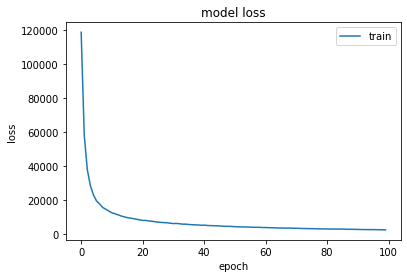

In [12]:

pyplot.plot(train_history.history['loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right');
pyplot.show()

In [15]:
''' 
return RP(reconstruction probabilities), p(x|x`),p(x|mu,sigma**2)
 X: inputs
 mu,sigma from the outputs
 RP could be used in training phase or testing phase.
'''

# only for multivariate Gaussian including MultivariateNoramlDiag() and MultivariateNormalTril()

#from scipy.stats import multivariate_normal
def RP_multivariate(x_orig,mu_post, sigma_post, L=1):
    '''
    args: 
    mu_post, sigma_post: come from the final decoder layer of test model or train model.
    x_orig: the inputs of test model or train model.
    L: the number of latent layers
    return:
    the probabilities of the distribution of x_orig on (mu_post,sigma_post) using multivariate Gaussian distribution.
    Another alternative method is original multivariate distribution model or mixture.
    '''
   
    recon_dist =tfp.distributions.MultivariateNormalDiag(mu_post,sigma_post)  # Multivariate Gaussian
    
    #scale=tf.matmul(sigma_post,sigma_post,transpose_a=True)  # Multivariate Gaussian full covariance 
    ##scale = tf.linalg.cholesky(sigma_post2)
    #recon_dist=tfd.MultivariateNormalTriL(mu_post,scale)
    reconstructed_prob=recon_dist.log_prob(x_orig)
    
    # scale data
    t = MinMaxScaler()
    reconstructed_prob=tf.reshape(reconstructed_prob,[-1,1])
    t.fit(reconstructed_prob)
    reconstructed_prob = t.transform(reconstructed_prob)
      
    return reconstructed_prob

def RP_normal_outp(x_orig,x_recons,L=1):
    '''    only for Normal distribution'''
    mu=tf.math.reduce_mean (x_recons,axis=1,keepdims=True)
    sigma=tf.clip_by_value( tf.math.reduce_std(x_recons, axis=1,keepdims=True), 1e-10, tf.reduce_max(x_recons))
    recon_dist =tfp.distributions.Normal(mu,sigma) 
    
    p=recon_dist.prob(x_orig)
    p1=tf.math.reduce_mean(p,axis=-1)  
    return p1

def RP_normal(x_orig,mu,sigma,L=1):
    '''     only for Normal distribution'''
    recon_dist =tfp.distributions.Normal(mu,sigma) 
    
    p=recon_dist.prob(x_orig)
    p1=tf.math.reduce_mean(p,axis=-1)  
    return p1

# save or load model

In [13]:
savename='cic2017-5-vi-iniput-Tril-bce'
# Save the weights
bae_model.save_weights('./cic2017_checkpoints/'+savename)

In [11]:
#load model

bae_model = BAE_AD(orig_dim=original_dim)
savename='cic2017-vi-last-bce'  #  None # to replace the file name
## Restore the weights
bae_model.load_weights('./cic2017_checkpoints/'+savename)  #, by_name=True)  #when using for transforming
savename='cic2017-5-vi-last-bce'  

# test model

In [15]:

from sklearn.decomposition import PCA

 # PCA 
 # latent:option1
 #examine the latent space generated by the encoder
def pca_latent(attackname,data_x):
    pca = PCA(n_components=2)
    X_transform = pca.fit_transform(data_x)

    # latent:option2
    pyplot.figure(figsize=(12, 10))
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
    pyplot.title(attackname)
    pyplot.grid()
    pyplot.show()

'\n    #  # latent:option3\n    # compare the above to the ground-truth plot below which actually shows the true labels of the data. \n    pyplot.figure(figsize=(12, 10))\n    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)\n    pyplot.title(attackname)\n    pyplot.grid()\n    pyplot.show()\n    '

In [ ]:

alluncertainty_dict={}
uncer_save_path = "plots/"+'BAE'+savename+'+alluncer'+".csv"

for attackindex in range(1,16):     #16, the 15th including all attack types  
    cont=np.load(dicnpy+"test-"+str(attackindex)+".npy",allow_pickle=True)
    print(f'the {attackindex}th attack data with name of {attack_types[attackindex]}')
    test_x,test_y=column_split_bina(cont)
    test_x = np.nan_to_num(test_x)
                
    if type(test_x)==False:
        print('test_x is False!')
    for i in range(0,len(test_y)):
        if test_y[i]!=0:
            test_y[i]=1

    # scale data
    t = MinMaxScaler()
    t.fit(test_x)
    test_x2 = t.transform(test_x)
            
    test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(bae_model,test_x2, 3,uqname='Kwon')   
    alluncertainty_dict[attack_types[attackindex]+'_orig'+'_total']=uq_alea+uq_epit
    alluncertainty_dict[attack_types[attackindex]+'_orig'+'_alea']=uq_alea
    alluncertainty_dict[attack_types[attackindex]+'_orig'+'_epis']=uq_epit
    if attackindex==1:
        try:
            plot_UQ_density(uq_alea,uq_epit, 90)                
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(test_recon)   
        
    #-------------------------------------------------# MAE---------------------------------------------------------
    #-----------------------------------anomaly scores------------------------
    #finding anomalies # anomaly value using MSE,MAE,crossentropy
    # 1.Reconstruction Error
    
    mae_vector = get_error_term(test_recon, test_x2, _rmse=False) 
    '''
    print("hist of mae_vector MAE")
    plot_hist(mae_vector)
    
    # plot roc-aut figure              
    bestthresh,bestfpr,_,_= rocauc(attack_types[attackindex]+'_MAE_Score',test_y,mae_vector)  
    print(f'best fpr: {bestfpr}')
    anomalies=mae_vector>bestthresh
    print(classification_report(test_y, anomalies)) 
    # measure using uncertainty by skip of anomaly probability
    #result_dic=plot_metrics(modelname='BAE',typename='score+'+attack_types[attackindex], ascores=mae_vector, 
     #                       unc_total=uq_alea+uq_epit, y_true=test_y,plot=False)
    '''
    #----------------------------------anomaly probability--------------------
    '''
    # test 1-------------------------------------
    # 1.the anomaly scores following Gaussian distribution
    
    mae_vector_prob=add_gaussian(mae_vector)
    mae_vector_prob=normalization_gaussian_1(mae_vector_prob)
    
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=alea_prob+epi_prob   
    result_dic=plot_metrics(modelname='BAE',typename='Gaussian+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
    
    
    # test 2-------------------------------------
    #the transferred anomaly scores following Gaussian distribution
    
    #mae_vector_prob=regular_log(mae_vector)
    mae_vector_prob=regular_linear(mae_vector)
    
    # the anomaly scores following Gaussian distribution
    mae_vector_prob=add_gaussian(mae_vector_prob)
    
    # four options for normalization.
    mae_vector_prob=normalization_gaussian_1(mae_vector_prob)
    #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
    #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
    #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=alea_prob+epi_prob       
    result_dic=plot_metrics(modelname='BAE',typename='GaussianScale+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
    '''
    # test 2.1  1-------------
    #mae_vector_prob=regular_log(mae_vector)
    mae_vector_prob=regular_linear(mae_vector)  ######################
    #mae_vector_prob=mae_vector
    # 1.the anomaly scores following Gaussian distribution
    #mae_vector_prob=add_gaussian(mae_vector_prob)
    mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
    
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=alea_prob+epi_prob     
    alluncertainty_dict[attack_types[attackindex]+'_GC'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_GC'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_GC'+'_epis']=epi_prob
    if attackindex==1:
        try:
            plot_UQ_density(alea_prob,epi_prob, 90)              
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)  
    
    #uncer_total=uq_alea+uq_epit   # uncer from output values
    result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total= uncer_total, y_true=test_y,plot=False)  #uncer_total
    result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False) 
                    
   
    # test 4   -------------------------------
    # 2.the anomaly scores following Gamma distribution      # not good at bae-vi
    
    #mae_vector_prob=regular_log(mae_vector)
    #mae_vector_prob=regular_linear(mae_vector)  ######################
    #mae_vector_prob= mae_vector
    #mae_vector_prob=add_gamma(mae_vector_prob)  
    mae_vector_prob=normalization_gamma(   mae_vector_prob)
    
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    #alea_prob,epi_prob=uq_alea, uq_epit
    uncer_total=alea_prob+epi_prob   
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+attack_types[attackindex], ascores=mae_vector_prob, 
                        unc_total=uncer_total, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False) 
    
    # test 5------------------------------------
    # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
    #3. alternative: pure cdf()   
    #mae_vector_prob=stats.norm.cdf(mae_vector)       
    '''
    # 3.1 ecdf       
    #mae_vector_prob=regular_log(mae_vector)
    mae_vector_prob=regular_linear(mae_vector)
    mae_vector_prob=normalization_ECDF_2(mae_vector_prob)
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=alea_prob+epi_prob       
    result_dic=plot_metrics(modelname='BAE',typename='ECDF2+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=uncer_total, y_true=test_y,plot=False)                            
    
    # test 6----------------------------------
    # ECOD in log()
    mae_vector_prob=regular_log(mae_vector)
    #mae_vector_prob=regular_linear(mae_vector)
    
    mae_vector_prob=normalization_ECOD(mae_vector_prob)    
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=alea_prob+epi_prob       
    result_dic=plot_metrics(modelname='BAE',typename='ECODLog+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
                            '''
        # test 6.1
        # ECOD linear()
    #mae_vector_prob=regular_log(mae_vector)       ######################### 
    #mae_vector_prob=regular_linear(mae_vector)     
    mae_vector_prob=normalization_ECOD(   mae_vector_prob)  
    mae_vector_prob=np.absolute(mae_vector_prob)
     # scale data
    t = MinMaxScaler()
    temp=tf.reshape(mae_vector_prob,[-1,1])
    t.fit(temp)
    temp = t.transform(temp)
    mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=alea_prob+epi_prob  
    alluncertainty_dict[attack_types[attackindex]+'_ECOD'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_ECOD'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_ECOD'+'_epis']=epi_prob
    
    if attackindex==1:
        try:
            plot_UQ_density(alea_prob,epi_prob, 90)              
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)  
        
    #uncer_total=uq_alea+uq_epit   # uncer from output values    
    result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total= uncer_total, y_true=test_y,plot=False)  #uncer_total

    result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False) 

    
  
    ''' after comparison and understanding, ignore the following part.
    #--------------------------------------------------------------# RMSE------------------------------------------------------------
    mae_vector = get_error_term(test_recon, test_x2) 
    print("hist of mae_vector RMAE")
    plot_hist(mae_vector)
    
    # plot roc-aut figure              
    bestthresh= rocauc(attack_types[attackindex]+'_RMSE',test_y,mae_vector)                   
    anomalies=mae_vector>bestthresh
    print(classification_report(test_y, anomalies))                 

    #end=time.time()  
    #print(f"\nTime to Testing: {round(end-start,5)} seconds.")
    #-----------------------------------------------------------#_prob()-------------------------------------------------------------
    # 2.Reconstruction Probability
    rp_vector=RP_multivariate(test_x2,test_recon_mu, test_recon_std)      
    print("hist of mae_vector prob")
    plot_hist(1-rp_vector)
    
    # plot roc-aut figure               
    bestthresh= rocauc(attack_types[attackindex]+'_Prob',test_y,1-rp_vector)
    print(bestthresh)
    anomalies=rp_vector<1-bestthresh
    print(classification_report(test_y, anomalies))                
    '''       
    
    '''  
    #***********************************************************RP for VAE, BAE**************************************
    # test 7
    rp_vector=RP_normal(test_x2,test_recon_mu, test_recon_std) 
    rp_vector=rp_vector.numpy()
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(1-rp_vector) 
    uncer_total=alea_prob+epi_prob       
    #uncer_total=uq_alea+uq_epit   # uncer from output values
    result_dic=plot_metrics(modelname='BAE',typename='RP+'+attack_types[attackindex], ascores=1-rp_vector, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
                 
    # test 7.1  using uncer from output
    rp_vector=RP_multivariate(test_x2,test_recon_mu, test_recon_std) 
    rp_vector=rp_vector.flatten()     
    uncer_total=uq_alea+uq_epit   # uncer from output values
    result_dic=plot_metrics(modelname='BAE',typename='RP2+'+attack_types[attackindex], ascores=1-rp_vector, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
    
    
    # test 8  not so good
    #recon_mu=np.mean(test_recon,axis=1)
    #recon_std=np.var(test_recon,axis=1)
    rp_vector=RP_normal_outp(test_x2,test_recon)  
    rp_vector=rp_vector.numpy()
    alea_prob ,epi_prob = UQ_ale_epi_Kwon(1-rp_vector) 
    uncer_total=alea_prob+epi_prob       
    #uncer_total=uq_alea+uq_epit   # uncer from output values
    result_dic=plot_metrics(modelname='BAE',typename='RP2+'+attack_types[attackindex], ascores=1-rp_vector, 
                            unc_total=uncer_total, y_true=test_y,plot=False)
                            
    '''
    #break

    
    

# further testing+ more dist

the 1th attack data with name of FTP-Patator
aleatoric mean:  0.034673089000316494
epistemic mean:  0.060742527083178975


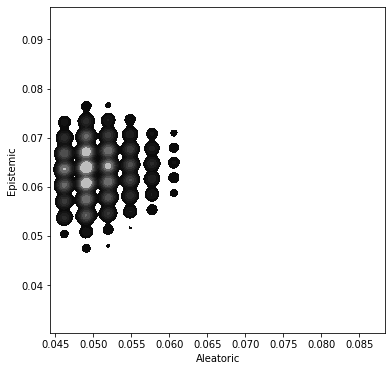

G1 hist of FTP-Patator
aleatoric mean:  0.05464680501207569
epistemic mean:  0.0003881586330968384


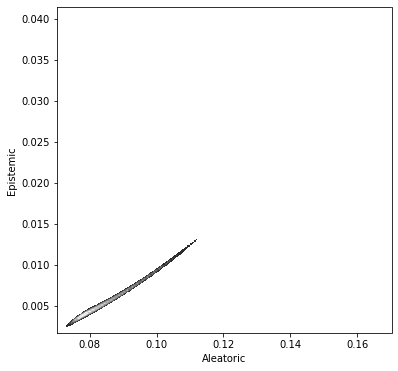

GC hist of FTP-Patator
aleatoric mean:  0.16664193981331546
epistemic mean:  0.08335805956660815


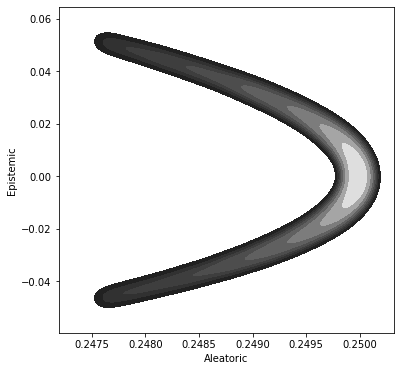

Gamma hist of FTP-Patator
aleatoric mean:  0.0
epistemic mean:  0.0
size of alearotic equals 0 when threshold=80


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

poisson hist of FTP-Patator
aleatoric mean:  0.013141930343269222
epistemic mean:  0.119961105593559
Contour levels must be increasing


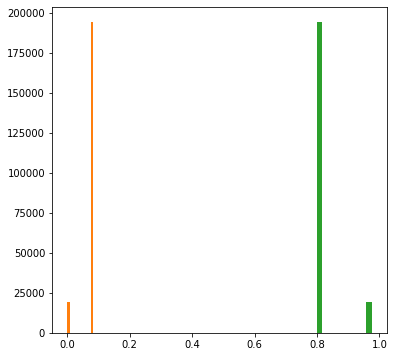

/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

Uniform hist of FTP-Patator
aleatoric mean:  0.18442128594153073
epistemic mean:  0.06427999343837253


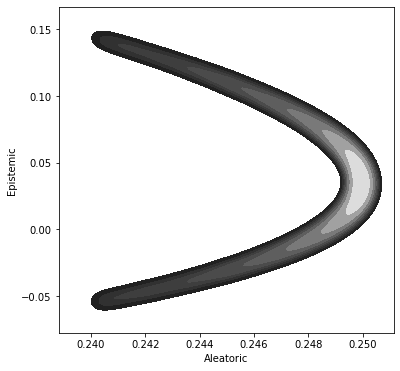

Triang hist of FTP-Patator
aleatoric mean:  0.1881641729741357
epistemic mean:  0.058500556942354696


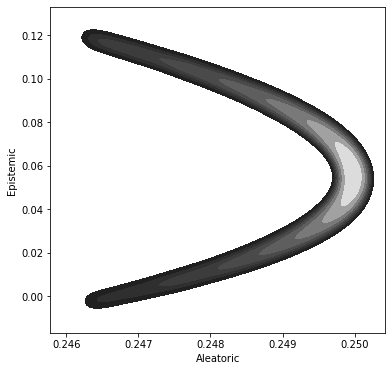

T hist of FTP-Patator
aleatoric mean:  0.08946647462131052
epistemic mean:  0.009282827201674648


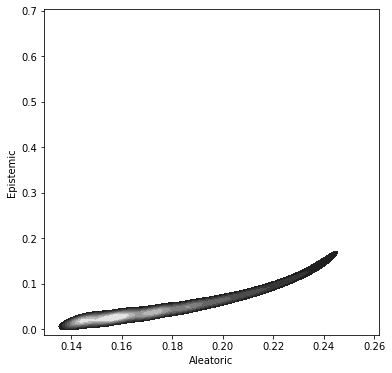

ECOD hist of FTP-Patator
aleatoric mean:  0.06374241873941827
epistemic mean:  0.005622436626207049


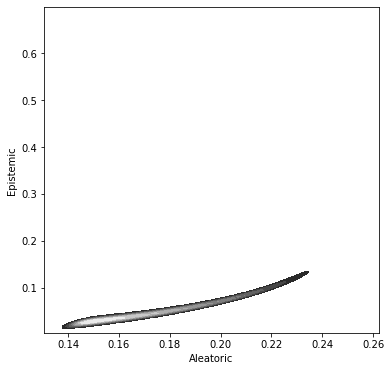

the 2th attack data with name of SSH-Patator


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 3th attack data with name of DoS GoldenEye


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 4th attack data with name of DoS Hulk


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 5th attack data with name of DoS Slowhttptest


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 6th attack data with name of DoS slowloris


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 7th attack data with name of Heartbleed


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 8th attack data with name of Web Attack � Brute Force


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 9th attack data with name of Web Attack � XSS


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 10th attack data with name of Web Attack � Sql Injection


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 11th attack data with name of Infiltration


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 12th attack data with name of Bot


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 13th attack data with name of DDoS


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 14th attack data with name of PortScan


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

the 15th attack data with name of AllAttack


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/teng

In [14]:

alluncertainty_dict={}
uncer_save_path = "plots/"+'BAE'+savename+'+alluncer'+".csv"

for attackindex in range(1,16):     #16, the 15th including all attack types  
    cont=np.load(dicnpy+"test-"+str(attackindex)+".npy",allow_pickle=True)
    print(f'the {attackindex}th attack data with name of {attack_types[attackindex]}')
    test_x,test_y=column_split_bina(cont)
    test_x = np.nan_to_num(test_x)
                
    if type(test_x)==False:
        print('test_x is False!')
    for i in range(0,len(test_y)):
        if test_y[i]!=0:
            test_y[i]=1

    # scale data
    t = MinMaxScaler()
    t.fit(test_x)
    test_x2 = t.transform(test_x)

    
    test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(bae_model,test_x2, 3,uqname='Kwon')   
    alluncertainty_dict[attack_types[attackindex]+'_orig'+'_total']=uq_alea+uq_epit
    alluncertainty_dict[attack_types[attackindex]+'_orig'+'_alea']=uq_alea
    alluncertainty_dict[attack_types[attackindex]+'_orig'+'_epis']=uq_epit
    if attackindex==1:
        try:
            plot_UQ_density(uq_alea,uq_epit, 90)                
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(test_recon)   
        
    #-------------------------------------------------# MAE---------------------------------------------------------
    #-----------------------------------anomaly scores------------------------
    #finding anomalies # anomaly value using MSE,MAE,crossentropy
    # 1.Reconstruction Error
    mae_vector = get_error_term(test_recon, test_x2, _rmse=False) 
    
    # test 2.1------# 1.the anomaly scores following Gaussian distribution--
    mae_vector_prob=copy.deepcopy(mae_vector)
    mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob)  # UQ_ale_epi_Kendall(test_recon_mu,test_recon_std)
    uncer_total=getsortedindex(alea_prob,epi_prob    )     
    alluncertainty_dict[attack_types[attackindex]+'_G1'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_G1'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_G1'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("G1 hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 90)                
        except:
            plot_hist(mae_vector_prob)

    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gaussian1+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=uncer_total, y_true=test_y,plot=False)  #uncer_total
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gaussian1+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gaussian1+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=epi_prob, y_true=test_y,plot=False) 



    ##---------------------------------------------------------------------
    
    mae_vector_prob=copy.deepcopy(mae_vector)

    # 1.the anomaly scores following Gaussian Custom distribution
    mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

    mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
    mae_vector_prob=np.absolute(mae_vector_prob)

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob  )   
    alluncertainty_dict[attack_types[attackindex]+'_GC'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_GC'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_GC'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("GC hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 90)                
        except:
            plot_hist(mae_vector_prob)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total= uncer_total, y_true=test_y,plot=False)  #uncer_total

    result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BAE'+savename,typename='GaussianCustom+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False) 


    # 2.the anomaly scores following Gamma distribution       # not good at bae-vi

    mae_vector_prob=copy.deepcopy(mae_vector )               
    #mae_vector_prob=add_gamma(mae_vector_prob)                
    mae_vector_prob=normalization_gamma(mae_vector_prob)

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob  ) 
    alluncertainty_dict[attack_types[attackindex]+'_Gamma'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_Gamma'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_Gamma'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("Gamma hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 80)                
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)

    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=uncer_total, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=alea_prob, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Gamma+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=epi_prob, y_true=test_y,plot=False)


     # 2.the anomaly scores following poisson distribution   ------------------------------  

    #mae_vector_prob=regular_log(mae_vector)
    mae_vector_prob=regular_linear(mae_vector)
    #mae_vector_prob=mae_vector                
    mae_vector_prob=add_poisson(mae_vector_prob)                
    mae_vector_prob=normalization_poisson(mae_vector_prob)

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob   )
    alluncertainty_dict[attack_types[attackindex]+'_Poisson'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_Poisson'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_Poisson'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("poisson hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 80)                
        except:
            print("Poisson hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)

    result_dic=plot_metrics(modelname='BAE'+savename,typename='Poisson+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=uncer_total, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Poisson+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=alea_prob, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Poisson+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=epi_prob, y_true=test_y,plot=False)


     # 2.the anomaly scores following uniform distribution -----------------------------------     

    #mae_vector_prob=regular_log(mae_vector)
    mae_vector_prob=regular_linear(mae_vector)
    #mae_vector_prob=mae_vector                
    mae_vector_prob=add_uniform(mae_vector_prob)                
    mae_vector_prob=normalization_uniform(mae_vector_prob)

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob )               
    alluncertainty_dict[attack_types[attackindex]+'_Uniform'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_Uniform'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_Uniform'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("Uniform hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 80)                
        except:
            print(" hist of "+attack_types[attackindex])
            plot_hist(mae_vector_prob)

    result_dic=plot_metrics(modelname='BAE'+savename,typename='Uniform+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=uncer_total, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Uniform+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=alea_prob, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Uniform+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=epi_prob, y_true=test_y,plot=False)

     # 2.the anomaly scores following studentst distribution   ----------------------------------    

    #mae_vector_prob=regular_log(mae_vector) # in this sentence, mean(mae_vector_prob) may>1, this leads argument error in stats.triang.rvs()
    mae_vector_prob=regular_linear(mae_vector)
    #mae_vector_prob=mae_vector                
    mae_vector_prob=add_triang(mae_vector_prob)                
    mae_vector_prob=normalization_triang(mae_vector_prob)

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob )                 
    alluncertainty_dict[attack_types[attackindex]+'_Triang'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_Triang'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_Triang'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("Triang hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 80)                
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)

    result_dic=plot_metrics(modelname='BAE'+savename,typename='Triang+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=uncer_total, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Triang+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=alea_prob, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='Triang+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=epi_prob, y_true=test_y,plot=False)

     # 2.the anomaly scores following studentst distribution   ----------------------------------    

    #mae_vector_prob=regular_log(mae_vector)
    #mae_vector_prob=regular_linear(mae_vector)
    mae_vector_prob=copy.deepcopy(mae_vector)                
    #mae_vector_prob=add_t(mae_vector_prob)                
    mae_vector_prob=normalization_t(mae_vector_prob)

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob  )                
    alluncertainty_dict[attack_types[attackindex]+'_T'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_T'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_T'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("T hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 80)                
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)

    result_dic=plot_metrics(modelname='BAE'+savename,typename='T+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=uncer_total, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='T+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=alea_prob, y_true=test_y,plot=False)
    result_dic=plot_metrics(modelname='BAE'+savename,typename='T+'+attack_types[attackindex], ascores=mae_vector_prob, 
                unc_total=epi_prob, y_true=test_y,plot=False)


    # test 6.1----------------------------------------------------------------
    mae_vector_prob=regular_log(mae_vector)       ###################### 
    #mae_vector_prob=regular_linear(mae_vector)    
    #mae_vector_prob=copy.deepcopy(mae_vector)
    mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
    mae_vector_prob=np.absolute(mae_vector_prob)
     # scale data
    t = MinMaxScaler()
    temp=tf.reshape(mae_vector_prob,[-1,1])
    t.fit(temp)
    temp = t.transform(temp)
    mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

    alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector_prob) 
    uncer_total=getsortedindex(alea_prob,epi_prob ) 
    alluncertainty_dict[attack_types[attackindex]+'_ECOD'+'_total']=uncer_total
    alluncertainty_dict[attack_types[attackindex]+'_ECOD'+'_alea']=alea_prob
    alluncertainty_dict[attack_types[attackindex]+'_ECOD'+'_epis']=epi_prob

    if attackindex==1:
        try:
            print("ECOD hist of "+attack_types[attackindex])
            plot_UQ_density(alea_prob,epi_prob, 90)                
        except:
            print("hist of test_recon "+attack_types[attackindex])
            plot_hist(mae_vector_prob)      
   
    result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total= uncer_total, y_true=test_y,plot=False)  #uncer_total

    result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=alea_prob, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BAE'+savename,typename='ECODLinear+'+attack_types[attackindex], ascores=mae_vector_prob, 
                            unc_total=epi_prob, y_true=test_y,plot=False) 



    #break

    
    

In [15]:

# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=savename,index=True)

## plot 3 uncertainty

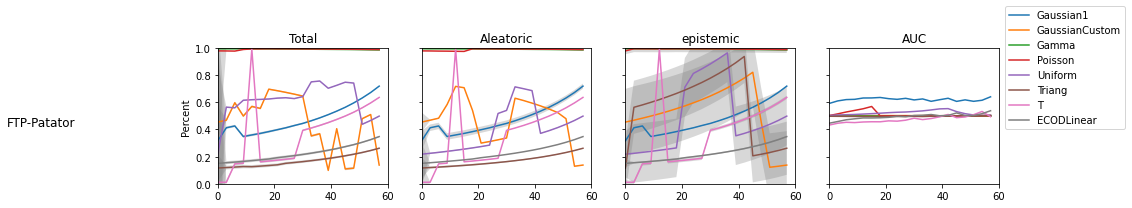

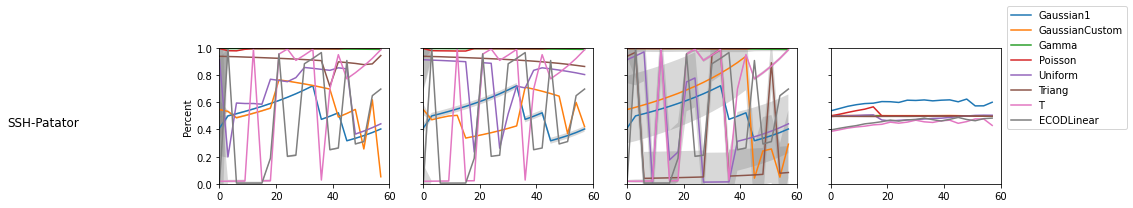

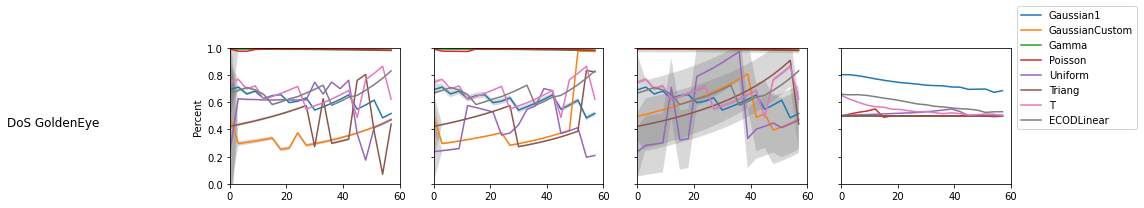

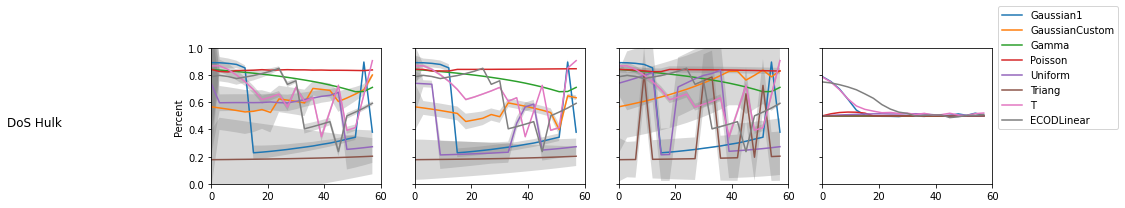

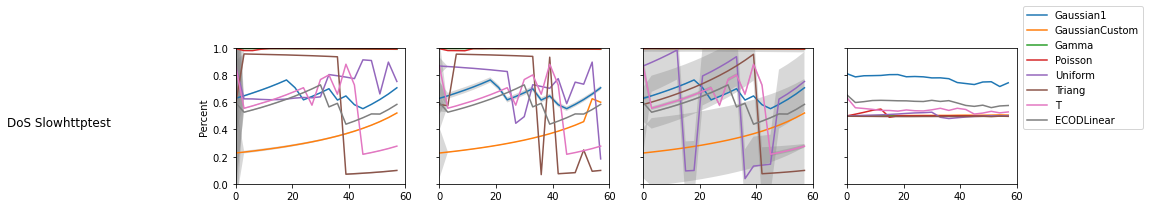

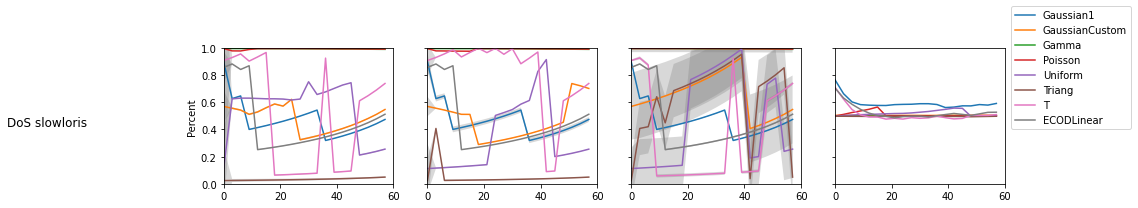

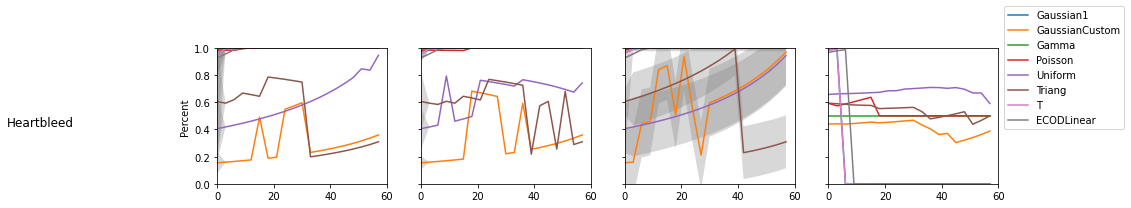

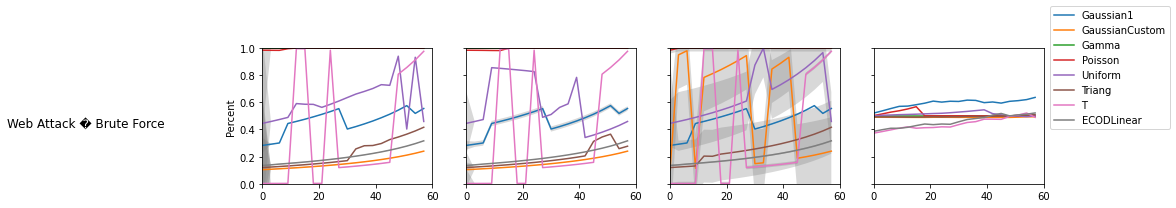

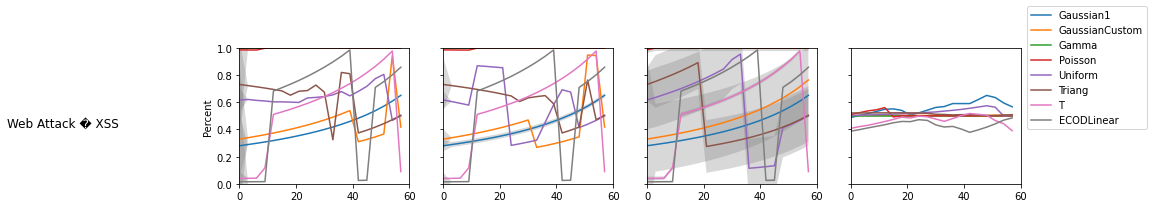

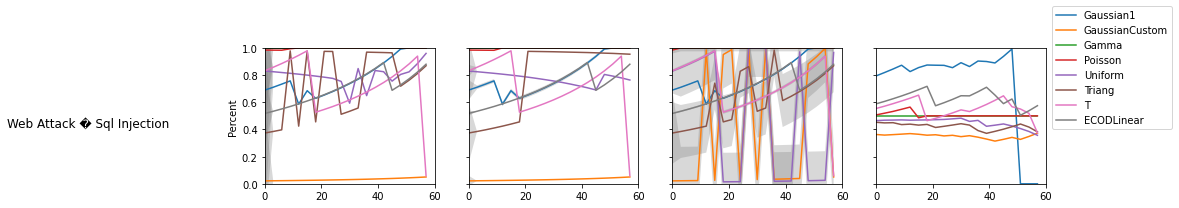

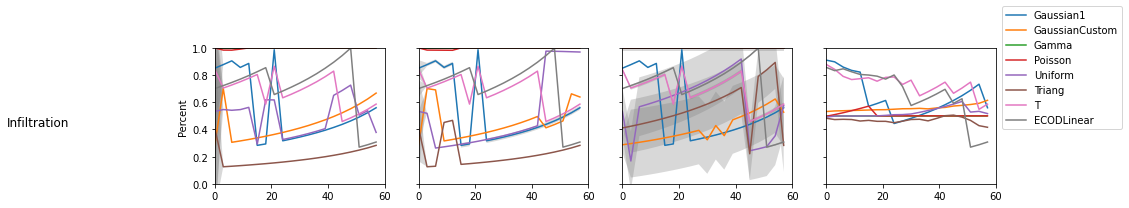

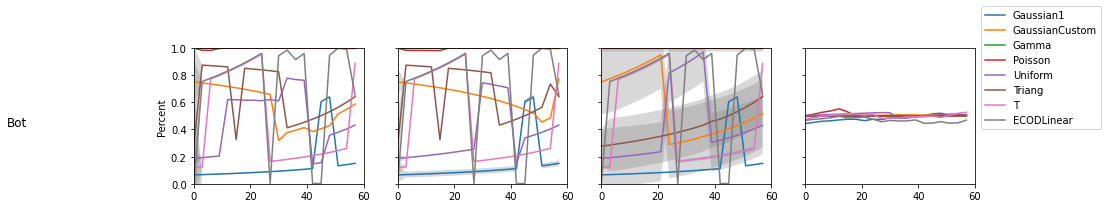

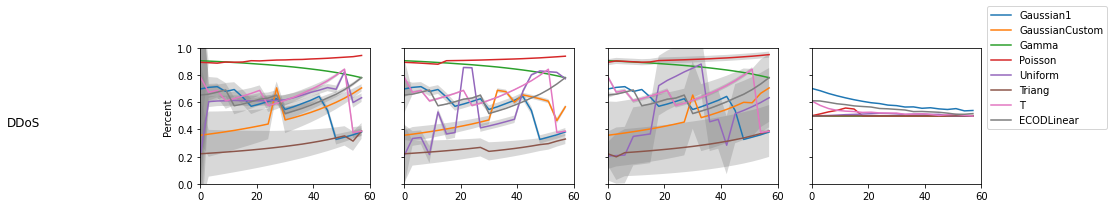

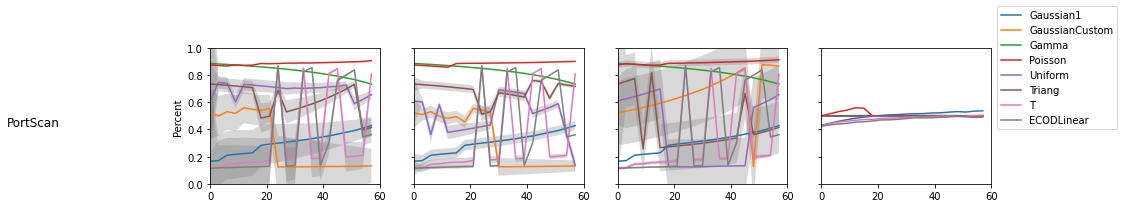

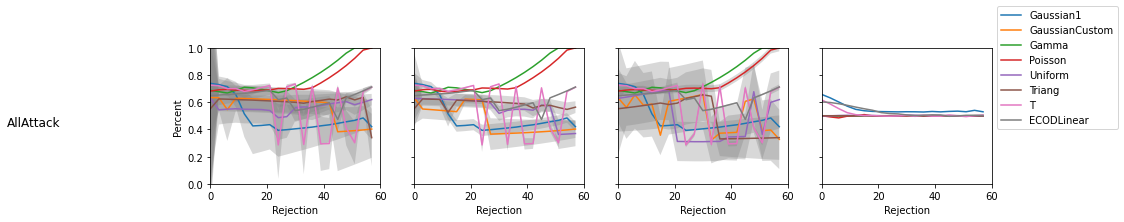

In [16]:
#savename='cic2017-3-vi-vae-bce'
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE'+savename+'+allmetrics.csv' )  #,skiprows=251)   
#print(pd_reader.head())
modelname='BAE'
model_dict_total={}
model_dict_alea={}
model_dict_epis={}
model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    
    for i in range(1,len(pd_reader) ,18*3):
        if '+' in pd_reader.iloc[i,0] :
            
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict_total.keys():
                    model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                    model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                    model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)
                else: 
                    model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                    model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                    model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16) 
                    
                #fig_title=pd_reader.iloc[i,0]
                try:
                    xx=pd_reader.iloc[i+2,1:].astype(int)
                except:
                    print(i)
                    
                # total uncertainty
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                y_uncer2=pd_reader.iloc[i+15+18,1:].astype(np.float16)  # alea
                y_uncer3=pd_reader.iloc[i+15+18*2,1:].astype(np.float16)   #epis
                #plot_title=pd_reader.iloc[i+2,0]            
                #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # auc
                y_values=pd_reader.iloc[i+9,1:].astype(np.float16)   # accu_total
                y_values2=pd_reader.iloc[i+9+18,1:].astype(np.float16)   # accu_alea
                y_values3=pd_reader.iloc[i+9+18*2,1:].astype(np.float16)   # accu_epis
                
                # ACCU_total
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU_alea
                ax2.plot(xx, y_values2) # , 'tab:green')        
                ax2.fill_between(xx,y_values2-np.absolute(y_uncer2),y_values2+np.absolute(y_uncer2),alpha=0.3,facecolor='grey')        
                # ACCU_epis
                ax3.plot(xx, y_values3 ) #, 'tab:orange') 
                ax3.fill_between(xx,y_values3-np.absolute(y_uncer3),y_values3+np.absolute(y_uncer3),alpha=0.3,facecolor='grey')         
                
                # AUC
                ax4.plot(xx, pd_reader.iloc[i+3,1:].astype(np.float16) ) # , 'tab:red') 
                
                #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test
                
                if each==1:
                    ax1.set_title('Total')
                    ax2.set_title('Aleatoric') 
                    ax3.set_title('epistemic')
                    ax4.set_title('AUC') 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    '''    
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)  
    
    pyplot.savefig('plots/'+savename+'+'+"alluncer.png")
    '''
    pyplot.show()
    
for aproblegend in model_dict_total.keys():
    if aproblegend != 'metricname':
        model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)
        model_dict_alea[aproblegend]=model_dict_alea[aproblegend]/(len(attack_types)-1)
        model_dict_epis[aproblegend]=model_dict_epis[aproblegend]/(len(attack_types)-1)
        
save_path = "plots/BAE"+savename+'+allmetricsSum'+".csv"

save_data=pd.DataFrame(model_dict_total)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_dict_alea)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_dict_epis)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

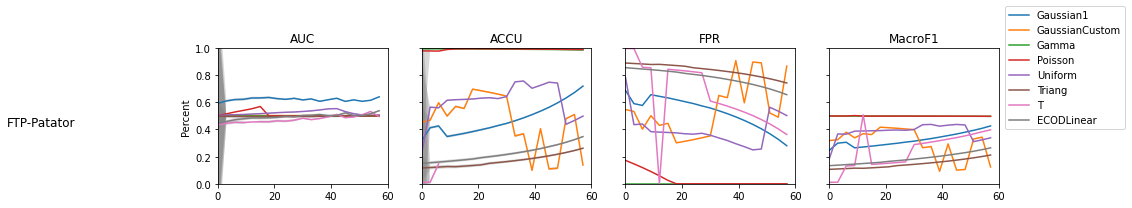

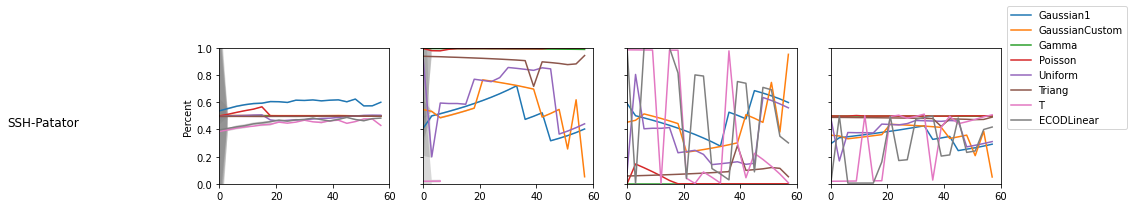

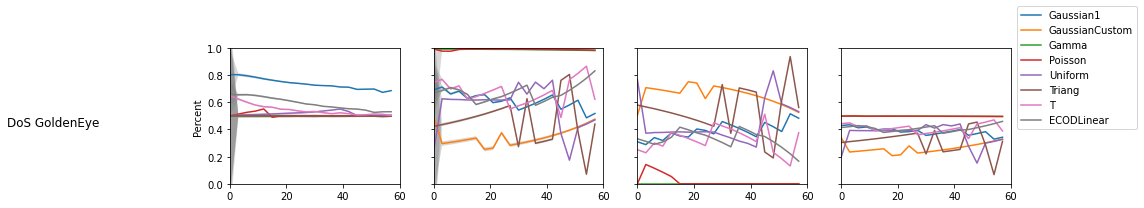

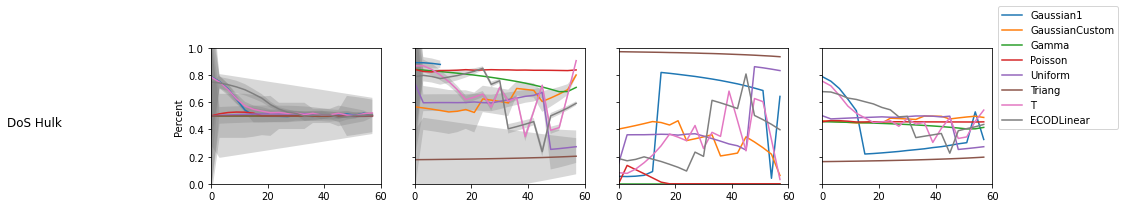

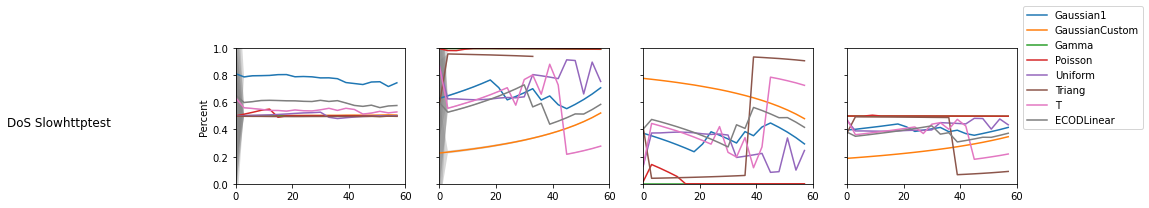

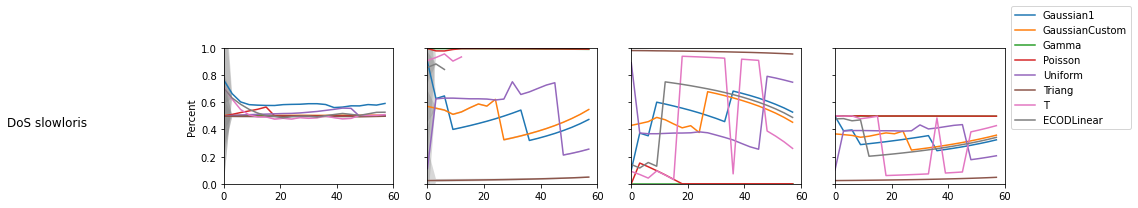

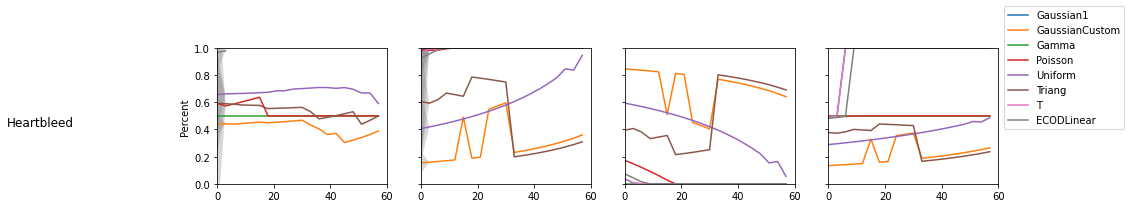

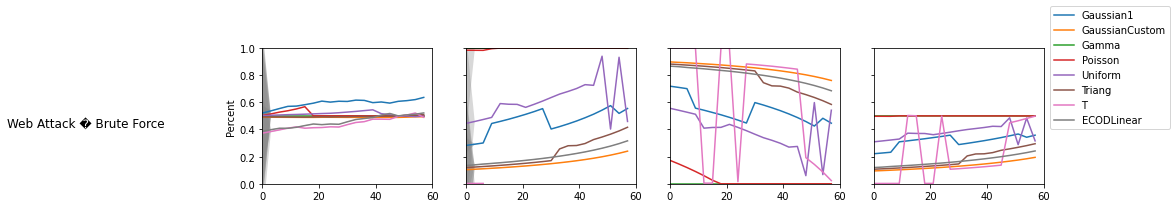

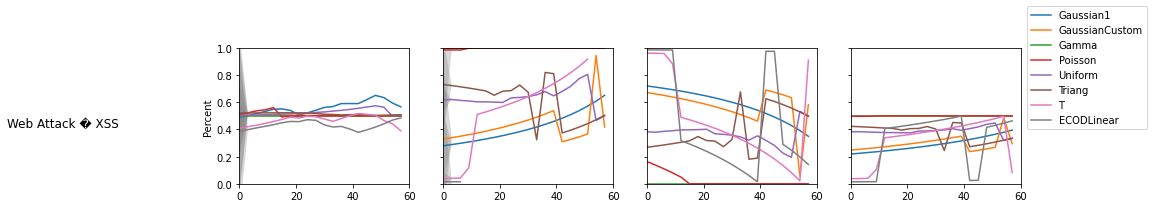

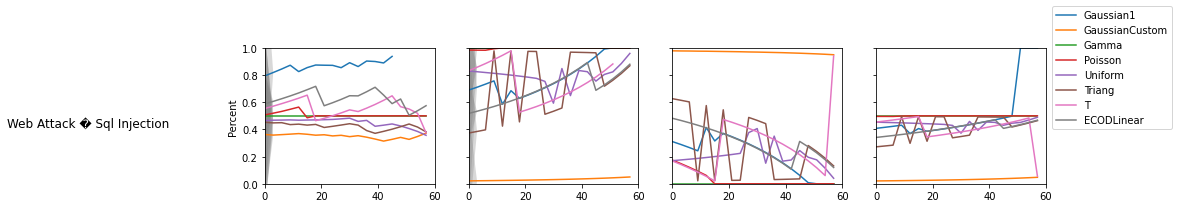

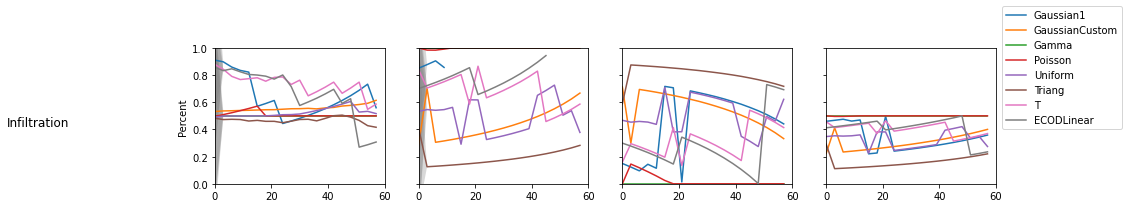

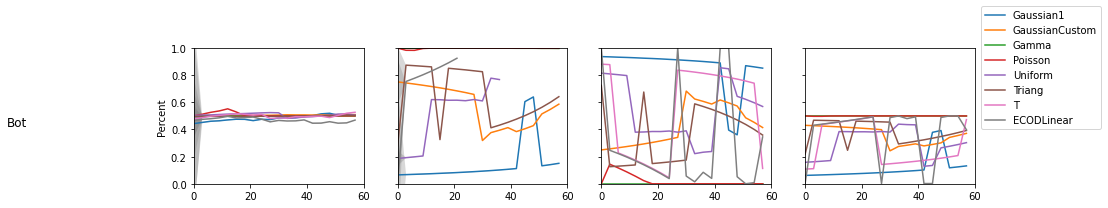

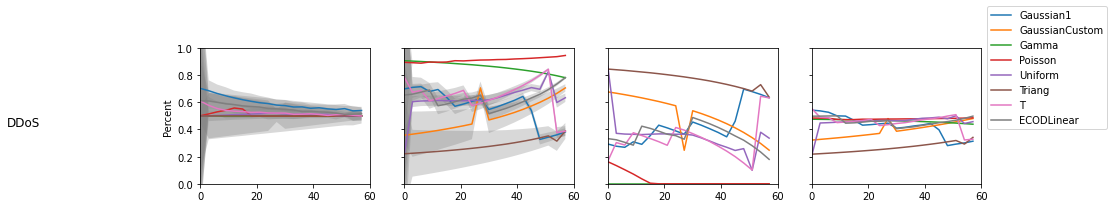

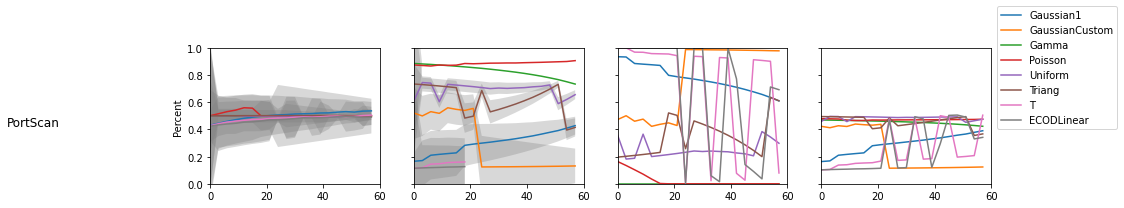

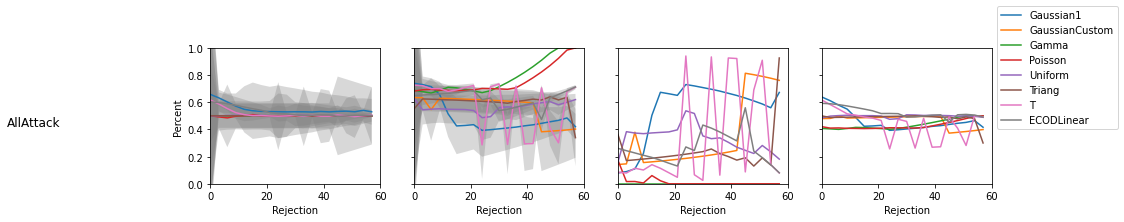

In [17]:
# for part sum under conditions
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE'+savename+'+allmetrics.csv' )  #,skiprows=251)

model_part={}
model_part['label']=["avgAUC","avgAccu","avgMacro"]
model_dict_total={}
model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    i=1
    while i <len(pd_reader):
        if '+' in pd_reader.iloc[i,0] :
            flag=False
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]                   
                    
                #fig_title=pd_reader.iloc[i,0]
                try:
                    xx=pd_reader.iloc[i+2,1:].astype(int)
                except:
                    print(i)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # AUC
                y_accu=pd_reader.iloc[i+9,1:].astype(np.float16) 
                y_macro=pd_reader.iloc[i+11,1:].astype(np.float16)
            
                y_uncer=np.absolute(y_uncer)
                party_auc=y_values
                party_accu=y_accu
                party_macro=y_macro
                partx_auc, partx_accu, partx_macro=xx,xx,xx
                partuncer_auc, partuncer_accu, partuncer_macro=y_uncer,y_uncer, y_uncer
                   # for remove angles
                for ind in range(2,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.6:
                        party_auc=y_values[:(ind-1)]                        
                        partx_auc=xx[:(ind-1)]
                        partuncer_auc=y_uncer[:(ind-1)]
                        break
                for ind in range(2,len(y_accu)):
                    if np.abs((y_accu[ind-1]-y_accu[ind]))>0.6:
                        party_accu=y_accu[:(ind-1)]                        
                        partx_accu=xx[:(ind-1)]
                        partuncer_accu=y_uncer[:(ind-1)]
                        break
                for ind in range(2,len(y_macro)):
                    if np.abs((y_macro[ind-1]-y_macro[ind]))>0.6:
                        party_macro=y_macro[:,(ind-1)]                        
                        partx_macro=xx[:,(ind-1)]
                        partuncer_macro=y_uncer[:,(ind-1)]
                        break
                        
                # AUC
                ax1.plot(partx_auc,party_auc,label=legendd)                
                ax1.fill_between(partx_auc,party_auc-partuncer_auc, party_auc+partuncer_auc,alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(partx_accu,party_accu)
                ax2.fill_between(partx_accu, party_accu-partuncer_accu, party_accu+partuncer_accu, alpha=0.3, facecolor='grey' ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # Macro F1
                ax4.plot(partx_macro,party_macro)
                #ax4.fill_between(partx_macro, party_macro-partuncer_macro, party_macro+partuncer_macro, alpha=0.3,facecolor='grey' ) # , 'tab:red') 
                
                #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+10,0]) 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
               
                
                if legendd in model_dict_total.keys():
                    model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)      
                    
                    model_part[legendd+"part"]=np.average([model_part[legendd+"part"], [np.mean(party_auc),np.mean(party_accu),np.mean(party_macro)]],axis=0)
                    #print(model_part["part"])
                else: 
                    model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16) 
                    model_part[legendd+"part"]=[np.mean(party_auc),np.mean(party_accu),np.mean(party_macro)]
                
                flag=True
                i=i+18*3
        if not flag:
            i=i+1
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
  
    pyplot.show()
    
for aproblegend in model_dict_total.keys():
    if aproblegend != 'metricname':
        model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)

save_path = "plots/BAE"+savename+'+allmetricsPartSum'+".csv"

save_data=pd.DataFrame(model_dict_total)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_part)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [20]:
print(savename)

cic2017-4-drop-latent-Tril-he-mae


#  RP

# plot total figures

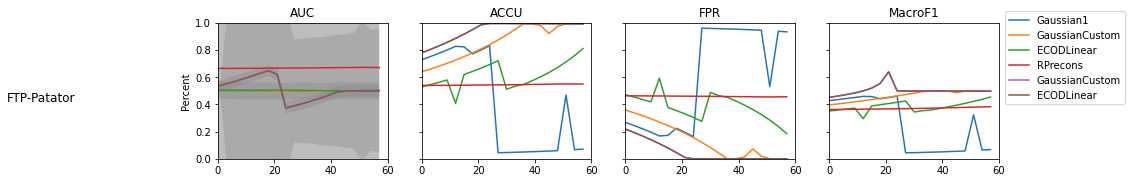

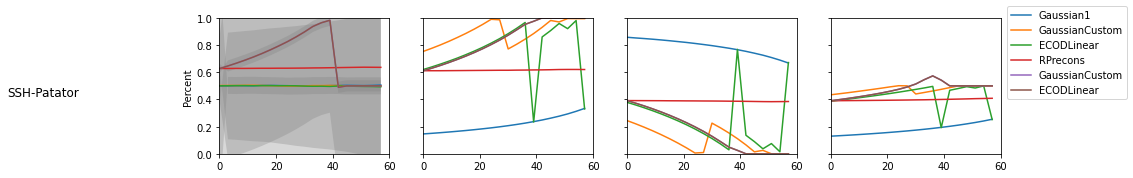

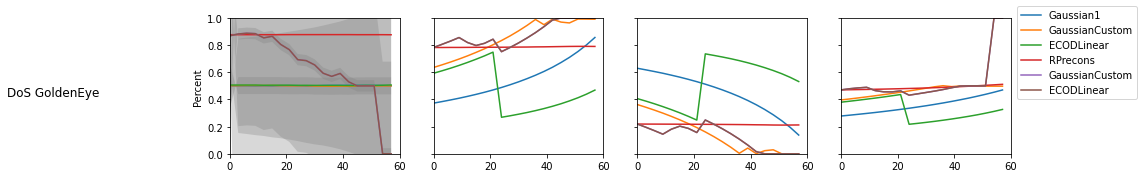

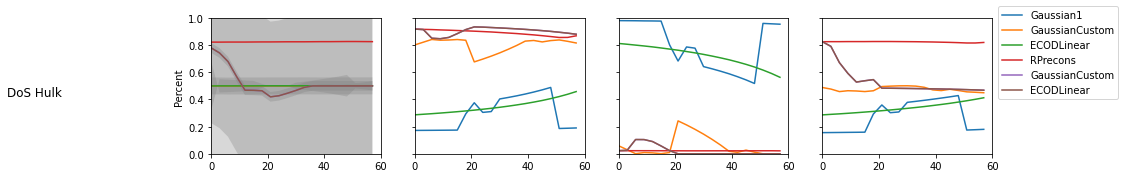

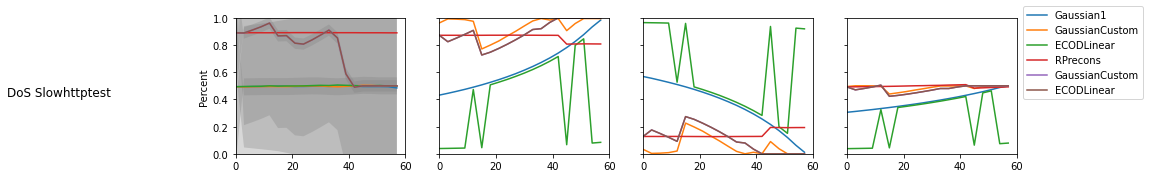

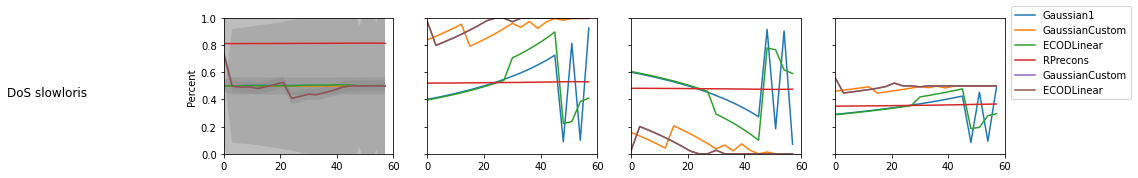

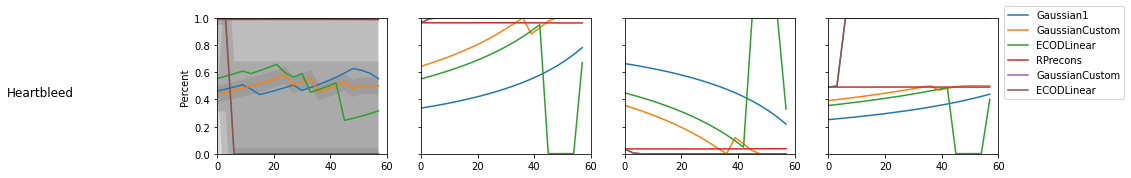

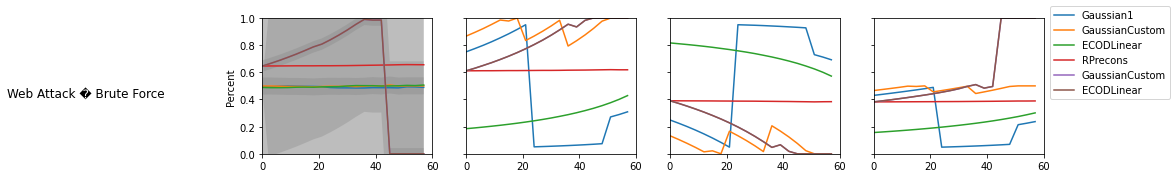

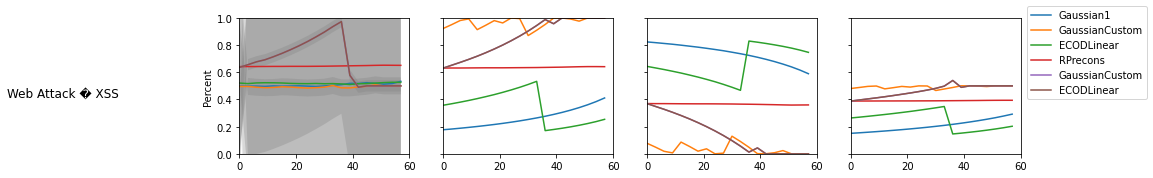

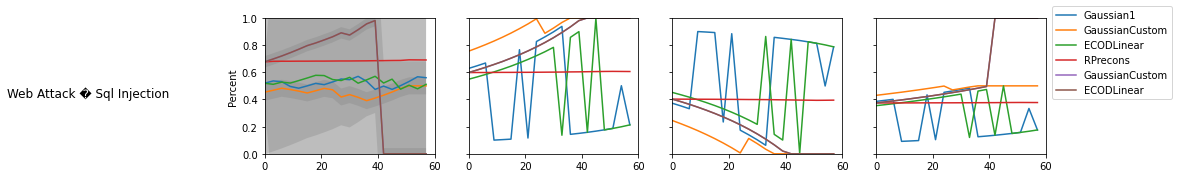

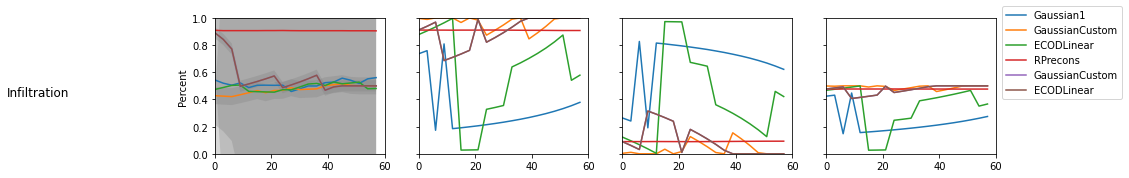

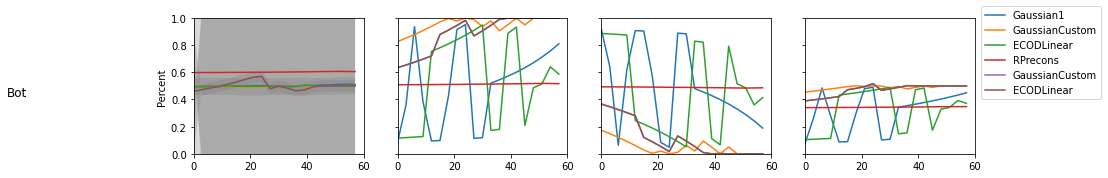

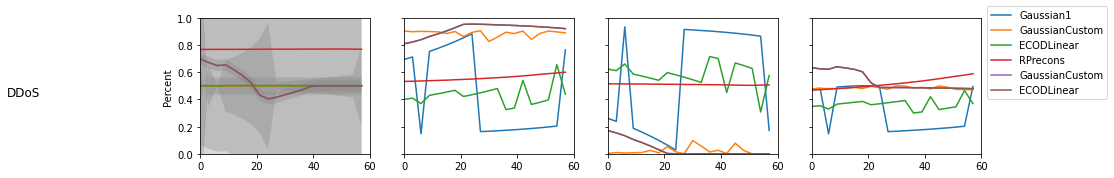

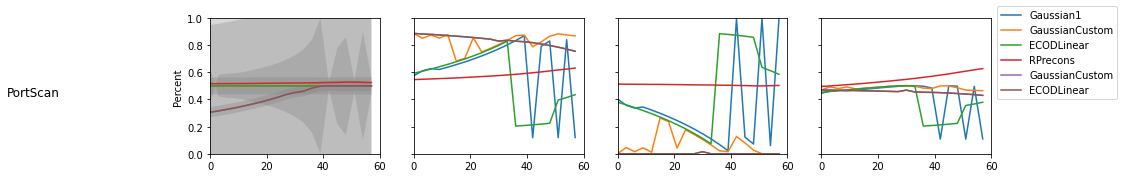

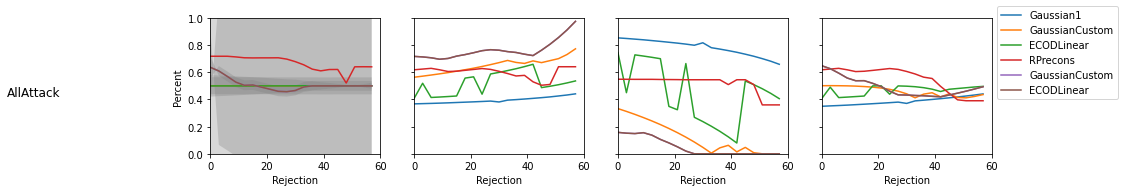

the AUC of this model is 0.6837758719921112


In [18]:
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE+allmetrics.csv' )  #,skiprows=251)

# plot comparision in different phase of each type
total_auc=0 # average of the largest AUC of each types
modelname='BAE MCdropout'
tw_auc,tw_accu=0,0
model_dict={}
model_dict["metricname"]=pd_reader.iloc[17,1:11]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    best_auc=0
    w_auc=0  #average
    w_accu=0  # average
    for i in range(0,len(pd_reader)):
        if '+' in pd_reader.iloc[i,0] :
            if pd_reader.iloc[i,0].split('+')[1]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict.keys():
                    model_dict[legendd]=(model_dict[legendd]+pd_reader.iloc[i+17,1:11].astype(np.float16))/2.0
                else: 
                    model_dict[legendd]=pd_reader.iloc[i+17,1:11].astype(np.float16)     
                    
                #fig_title=pd_reader.iloc[i,0]
                xx=pd_reader.iloc[i+2,1:].astype(int)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)
                
                if best_auc<  np.max(y_values):
                    best_auc=np.max(y_values)
                if w_auc<float(pd_reader.iloc[i+17,2]):
                    w_auc=float( pd_reader.iloc[i+17,2])
                    # print(f'the better weight_auc {w_auc}is belongs: {attack_types[each]}{legendd}')
                if w_accu<float(pd_reader.iloc[i+17,3]):
                    w_accu=float(pd_reader.iloc[i+17,3])
                    #print(f'the better weight_accu {w_accu}is belongs: {attack_types[each]}{legendd}')
                '''    # for remove angles
                for ind in range(1,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.6:
                        yyy=y_values[:,ind-1]                        
                        xxx=xx[:,ind-1]
                        '''
                # AUC
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-y_uncer,y_values+y_uncer,alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(xx, pd_reader.iloc[i+9,1:].astype(np.float16) ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # Macro F1
                ax4.plot(xx, pd_reader.iloc[i+11,1:].astype(np.float16) ) # , 'tab:red')               
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+10,0]) 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
                i=i+18  
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    '''
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)    
    pyplot.savefig('plots/'+modelname+'+'+nowtime+'+'+"allmetrics.png")
    '''
    pyplot.show()
    
         
print(f'the AUC of this model is {total_auc}')
save_path = "plots/"+'allmetrics'+".csv"
#final_AUC={'total_AUC':total_auc, 'weight_AUC:':tw_auc,'weight_Accu:':tw_accu}
#save_data = pd.DataFrame.from_dict([final_AUC])
#save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

save_data=pd.DataFrame(model_dict)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

# plot models

In [1]:
# plot comparision in different model of each type
fig, axes= pyplot.subplots(3, 5,figsize=(18,10),sharex=True,sharey=True) 
fig.suptitle('Comparisons of Models' ) 
diccsv='csvs-2/'
for indtype in range(1,len( attack_types)): 
    axes[(indtype-1)//5,(indtype-1)%5].set_title(attack_types[indtype] )
    
    for root,dirs,files in os.walk(diccsv):
        for each in files:
            if each.endswith('.csv') and each.split('-')[-1]!='checkpoint.csv' :  
                thislabel=each.split('+')[0]
                pd_reader=pd.read_csv(diccsv+each)
                init=0
                
                for i in range(init,len(pd_reader)): # show the first group results in csv
                    if '+' in pd_reader.iloc[i,0]:
                        if pd_reader.iloc[i,0].split('+')[1]==attack_types[indtype] and pd_reader.iloc[i,0].split('+')[0]=='GaussianCustom' : #'ECODLinear': # 
                           
                            xx=pd_reader.iloc[i+2,1:].astype(int)
                            y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                            #plot_title=pd_reader.iloc[i+2,0]            
                            #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # AUC

                            #y_values=pd_reader.iloc[i+5,1:].astype(np.float16)  # GSS

                            y_values=pd_reader.iloc[i+9,1:].astype(np.float16)  # Accu
                            
                            axes[(indtype-1)//5,(indtype-1)%5].plot(xx,y_values,label=thislabel)
                            #ax1.fill_between(xx,y_values-y_uncer,y_values+y_uncer,alpha=0.3,facecolor='grey')
                            #ax1.set(ylabel='Percent')
                        
                            break
                            #i=i+18  
handles, labels = axes[0,2].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1,0.5))

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(0,60)
    ax.set_ylim(0,1)

nowtime=datetime.datetime.now()
nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)
pyplot.savefig('csvs/comparison+'+nowtime+'+'+"allmodels.png")
pyplot.show()

NameError: name 'pyplot' is not defined